In [1]:
# import modules
import uproot, sys, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from scipy.special import betainc
from scipy.stats import norm

# import config functions
from plot_config import getWeight, zbi, sample_dict, getVarDict
from plot_var import variables, ntuple_name, ntuple_name_BDT


# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 14
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [2]:
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"
path = "/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_ggHyyd_y_BDT_score.root"
f = uproot.open(path)['nominal']
f.keys()

['run',
 'randomRunNumber',
 'event',
 'year',
 'averageIntPerXing',
 'actualIntPerXing',
 'corAverageIntPerXing',
 'corActualIntPerXing',
 'trigger_HLT_g100_loose_L1EM22VHI',
 'trigger_HLT_g100_loose_L1eEM26M',
 'trigger_HLT_g100_loose_L1eEM28M',
 'trigger_HLT_g120_loose_L1EM22VHI',
 'trigger_HLT_g120_loose_L1eEM26M',
 'trigger_HLT_g120_loose_L1eEM28MHLT_g25_loose_L1EM20VH',
 'trigger_HLT_g140_loose_L1EM22VHI',
 'trigger_HLT_g140_loose_L1eEM26M',
 'trigger_HLT_g25_loose_L1eEM24L',
 'trigger_HLT_g30_loose_L1EM20VH',
 'trigger_HLT_g30_loose_L1eEM24L',
 'trigger_HLT_g40_loose_L1EM20VH',
 'trigger_HLT_g40_loose_L1eEM24L',
 'trigger_HLT_g50_loose_L1EM20VH',
 'trigger_HLT_g50_loose_L1eEM24L',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe70_pf

In [ ]:
f['ph_topoetcone40']

IndexError: list index out of range

In [2]:
tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

# i = 0
for i in range(len(ntuple_name)):
    ucut, wcut = [], []
    start_time = time.time()
    path = f"/data/tmathew/ntups/mc23d/{ntuple_name[i]}_y.root" 
    path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name_BDT[i]}_y_BDT_score.root" 
    print('processing file: ', path)
    f = uproot.open(path)['nominal']
    fb = f.arrays(variables, library="ak")

    # add BDT score to fb
    f_BDT = uproot.open(path_BDT)['nominal']
    fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
    tmp = fb["event"] == fb_BDT["event"]
    if np.all(tmp) == True:
        fb["BDTScore"] = fb_BDT["BDTScore"]
    else: 
        print("Something is wrong, need arranging")
    

    print("Unweighted Events before cut: ", len(fb))
    print("Weighted Events before cut: ", sum(getWeight(fb, ntuple_name[i])))
    unweighted_bcut.append(len(fb))
    weighted_bcut.append(sum(getWeight(fb, ntuple_name[i])))


    fb = fb[fb['n_ph_baseline'] == 1]
    fb = fb[fb['n_ph'] == 1]
    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    fb = fb[fb['n_jet_central'] <= 4] # n_jet_central cut (basic cut)
    # goodPV on signal only
    if ntuple_name[i] == 'ggHyyd':
        fb = fb[ak.num(fb['pv_z']) > 0]
        good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
        fb = fb[good_pv_tmp]

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                            (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 100 # trigger cut
    fb = fb[mask1]
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))

    # fb = fb[fb['BDTScore'] >= 0.1] # added cut 1
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # metsig_tmp = fb['met_tst_sig'] # added cut 2 
    # mask1 = metsig_tmp >= 7
    # fb = fb[mask1]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # dphi_met_phterm_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) # added cut 3
    # fb = fb[dphi_met_phterm_tmp >= 1.35]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # dmet_tmp = fb['met_tst_noJVT_et'] - fb['met_tst_et'] # added cut 4
    # mask1 = dmet_tmp >= -20000
    # mask2 = dmet_tmp <= 50000
    # fb = fb[mask1 * mask2]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,   # added cut 5
    #                         np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
    #                         -999)
    # fb = fb[dphi_met_jetterm_tmp <= 0.7]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # ph_eta_tmp = np.abs(ak.firsts(fb['ph_eta'])) # added cut 6
    # fb = fb[ph_eta_tmp <= 1.75]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # phi1_tmp = ak.firsts(fb['jet_central_phi']) # added cut 7
    # phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1] 
    # dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    # dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
    # fb = fb[dphi_jj_tmp <= 2.5]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))


    # jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
    # expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
    # balance_tmp = ak.where(jet_sum_tmp != 0, expr, 999) 
    # fb = fb[balance_tmp >= 0.65]
    # ucut.append(len(fb))
    # wcut.append(sum(getWeight(fb, ntuple_name[i])))

    # mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
    #                     (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    # mask1 = mt_tmp >= 95
    # fb = fb[mask1]

    print("Unweighted Events after cut: ", len(fb))
    print("Weighted Events after cut: ", sum(getWeight(fb, ntuple_name[i])))
    ucut.append(len(fb))
    wcut.append(sum(getWeight(fb, ntuple_name[i])))


    unweighted_acut.append(ucut)
    # unweighted_acut.append(len(fb))
    weighted_acut.append(wcut)
    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name[i]}: {(time.time()-start_time)} seconds\n")



    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0


processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  225374
Weighted Events before cut:  22918.521
Unweighted Events after cut:  4575
Weighted Events after cut:  460.70255
Number of none values:  0
Reading Time for ggHyyd: 4.226085186004639 seconds

processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  11544081
Weighted Events before cut:  1739103.6
Unweighted Events after cut:  31608
Weighted Events after cut:  3366.5044
Number of none values:  0
Reading Time for Zjets: 128.04662704467773 seconds

processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  4341141
Weighted Events before cut:  310120.2
Unweighted Events after cut:  1712923
Weighted Events after cut:  52604.98
Number of none values:  0
Reading Time for Zgamma: 70.11236619949341 seconds

processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1772654
Weighted Events before cut:  567686.56
Un

In [9]:
sig/np.sqrt(bkg)

array([1.00000000e+00, 3.14641113e-03, 2.22485415e-03, 1.81658731e-03,
       1.57321140e-03, 1.40712341e-03, 1.28452226e-03, 1.18923667e-03,
       1.11242914e-03, 1.04880832e-03, 9.94986994e-04, 9.48682919e-04,
       9.08294777e-04, 8.72661422e-04, 8.40917611e-04, 8.12403613e-04,
       7.86606432e-04, 7.63120345e-04, 7.41619682e-04, 7.21839603e-04,
       7.03562225e-04, 6.86606435e-04, 6.70820276e-04, 6.56075179e-04,
       6.42261529e-04, 6.29285216e-04, 6.17064927e-04, 6.05529990e-04,
       5.94618650e-04, 5.84276671e-04, 5.74456199e-04, 5.65114828e-04,
       5.56214828e-04, 5.47722503e-04, 5.39607649e-04, 5.31843108e-04,
       5.24404378e-04, 5.17269294e-04, 5.10417745e-04, 5.03831435e-04,
       4.97493682e-04, 4.91389235e-04, 4.85504123e-04, 4.79825518e-04,
       4.74341619e-04, 4.69041548e-04, 4.63915258e-04, 4.58953456e-04,
       4.54147529e-04, 4.49489483e-04, 4.44971887e-04, 4.40587822e-04,
       4.36330836e-04, 4.32194906e-04, 4.28174401e-04, 4.24264052e-04,
      

In [38]:
s = 374.83
b = 227609

zbi(2.29e4, 2.34e10), zbi(374, 227609), zbi(217, 5066), zbi(147.7, 1556.67), zbi(101.79, 581.67)

(np.float64(-0.19902261854965286),
 np.float64(-0.19348348711297475),
 np.float64(-0.05665791480160304),
 np.float64(0.11042298299678163),
 np.float64(0.35498166701173955))

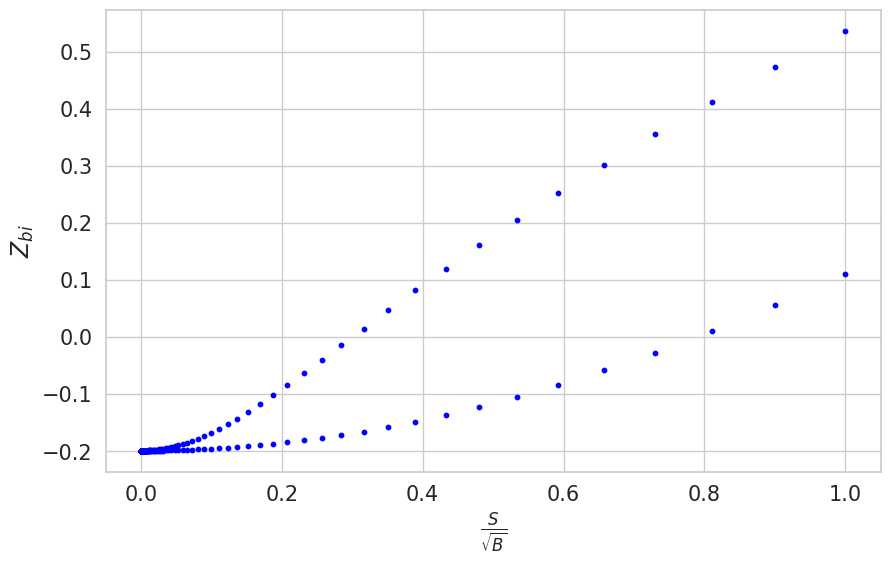

In [35]:
plt.figure(figsize=(10, 6))
sig  = 1
bkg = np.logspace(0, 9, 100)  # 10^0 = 1 to 10^7
plt.scatter(sig/np.sqrt(bkg), [zbi(sig, b) for b in bkg], color='blue', label='Zbi', s=10)
sig  = 1 * 10
bkg = np.logspace(0, 9, 100) * 100 # 10^0 = 1 to 10^7
plt.scatter(sig/np.sqrt(bkg), [zbi(sig, b) for b in bkg], color='blue', label='Zbi', s=10)
plt.xlabel(r'$\frac{S}{\sqrt{B}}$', fontsize=font_size["xlabel"])
plt.ylabel(r'$Z_{bi}$', fontsize=font_size["ylabel"])

plt.show()

In [36]:
# Table of before and after cut unweighted and weighted event
pd.DataFrame({
    'process_file': ntuple_name,
    'before_cut': weighted_bcut,
    'basic_cut': transposed_acut[0],
    'BDTScore_cut': transposed_acut[1],
    'metsig_cut': transposed_acut[2],
    'dphi_met_phterm_cut': transposed_acut[3],
    'dmet_cut': transposed_acut[4],
    'dphi_met_jetterm_cut': transposed_acut[5],
    'ph_eta_cut': transposed_acut[6],
    'dphi_jj_cut': transposed_acut[7],
    'balance_cut': transposed_acut[8]
    # 'selection ratio': np.array(weighted_acut)/np.array(weighted_bcut) * 100

    # 'weighted_before_cut': weighted_bcut,
    # 'after': unweighted_acut,
    # 'weighted_acut': weighted_acut,
})

NameError: name 'transposed_acut' is not defined

In [4]:
def sel(tot):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]

        # dphi_met_phterm_minus_dphi_met_jetterm_tmp =  np.where(fb2['met_jetterm_et'] > 0,
        #                     np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi'])) -
        #                     np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
        #                     -999)
        # mask1 = dphi_met_phterm_minus_dphi_met_jetterm_tmp >= 0.8
        # mask2 = dphi_met_phterm_minus_dphi_met_jetterm_tmp == -999
        # fb2 = fb2[mask1 | mask2]

        jet_sum_tmp = ak.sum(fb2['jet_central_pt'], axis=-1)
        expr = (fb2['met_tst_et'] + ak.firsts(fb2['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance_tmp = ak.where(jet_sum_tmp != 0, expr, -999)
        mask1 = balance_tmp >= 0.65
        mask2 = balance_tmp == -999
        fb2 = fb2[mask1 | mask2]
        
        metsig_tmp = fb2['met_tst_sig'] 
        mask1 = metsig_tmp >= 7
        mask2 = metsig_tmp <= 13
        fb2 = fb2[mask1 * mask2]
        
        ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta']))
        fb2 = fb2[ph_eta_tmp <= 1.75]

        dphi_met_phterm_tmp = np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi'])) # added cut 3
        fb2 = fb2[dphi_met_phterm_tmp >= 1.35]

        dmet_tmp = fb2['met_tst_noJVT_et'] - fb2['met_tst_et']
        mask1 = dmet_tmp >= -20000
        mask2 = dmet_tmp <= 50000
        fb2 = fb2[mask1 * mask2]

        phi1_tmp = ak.firsts(fb2['jet_central_phi']) # added cut 7
        phi2_tmp = ak.mask(fb2['jet_central_phi'], ak.num(fb2['jet_central_phi']) >= 2)[:, 1] 
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        dphi_jj_tmp = ak.fill_none(dphi_tmp, -999)
        fb2 = fb2[dphi_jj_tmp <= 2.5]

        dphi_met_jetterm_tmp = np.where(fb2['met_jetterm_et'] != 0,   # added cut 5
                            np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
                            -999)
        fb2 = fb2[dphi_met_jetterm_tmp <= 0.70]

        # mt_tmp = np.sqrt(2 * fb2['met_tst_et'] * ak.firsts(fb2['ph_pt']) * 
        #                     (1 - np.cos(fb2['met_tst_phi'] - ak.firsts(fb2['ph_phi'])))) / 1000
        # mask1 = mt_tmp >= 95
        # fb2 = fb2[mask1]

        
        tot2.append(fb2)
    return tot2

tot2 = sel(tot)
# tot2 = tot

cut_name = 'selection'
# var_config = getVarDict(tot2[0], 'ggHyyd', var_name='balance')
# cut_name = 'mt2'
var_config = getVarDict(tot2[0], 'ggHyyd')


for var in var_config:
    # print(var)
    bg_values = []     
    bg_weights = []    
    bg_colors = []     
    bg_labels = []     

    signal_values = [] 
    signal_weights = []
    signal_color = None 
    signal_label = None

    # for j in range(len(ntuple_name)):
    for j in range(len(ntuple_name)-1): # leave dijet out
        process = ntuple_name[j]
        fb = tot2[j]  # TTree
        var_config = getVarDict(fb, process, var_name=var)

        x = var_config[var]['var'] # TBranch
        bins = var_config[var]['bins'] 

        if 'weight' in var_config[var]:  # If weight is there
            weights = var_config[var]['weight']
        else:
            weights = getWeight(fb, process)
        # findnone(x)
        # findnone(weights)

        # mask = x != -999 # **Apply Cut: Remove -999 values**
        # x = x[mask]
        # weights = weights[mask]

        # weights = abs(weights) # Study of abosolute weight
        
        sample_info = sample_dict[process]
        color = sample_info['color']
        legend = sample_info['legend']

        
        if process == 'ggHyyd':  # signal
            signal_values.append(x)
            signal_weights.append(weights)
            signal_color = color
            signal_label = legend
        else:   # background
            bg_values.append(x)
            bg_weights.append(weights)
            bg_colors.append(color)
            bg_labels.append(legend)

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                label=bg_labels, stacked=True)

    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
    signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

    # Add error bar for signal (top plot)
    if len(signal_all) > 0:
        signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

        ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                        color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.minorticks_on()
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.set_ylabel("Events")
    ax_top.legend(ncol=2)
    # ax_top.set_title("vtx_sumPt distribution")

    bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
    bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

    # Compute the weighted histogram counts using np.histogram
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

    # Compute per-bin significance
    sig_simple = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)

    sqrt_B = np.sqrt(B_counts)
    sqrt_SplusB = np.sqrt(S_counts + B_counts)
    sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)

    # Avoid division by zero safely
    sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
    sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
    sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)

    # Add Binomial ExpZ per bin
    zbi_per_bin = np.array([
        zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
        for i in range(len(S_counts))
    ])

    # Compute the bin centers for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute the total significance: total S / sqrt(total B)
    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)

    if total_bkg > 0:
        total_sig_simple = total_signal / np.sqrt(total_bkg)
        total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
        total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
        total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
    else:
        total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0

    # --- Plot all significance curves ---
    ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                label=f"S/√B = {total_sig_simple:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
    ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

    ax_bot.set_xlabel(var_config[var]['title'])
    # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
    ax_bot.set_ylabel("Significance")
    ax_bot.set_ylim(-0.8, 2)
    ax_top.set_xlim(bins[0], bins[-1])

    # Do not set a title on the bottom plot.
    ax_bot.set_title("")

    # Draw a legend with purple text.
    leg = ax_bot.legend()
    for text in leg.get_texts():
        text.set_color('purple')

    plt.xlim(bins[0], bins[-1])
    plt.tight_layout()
    plt.savefig(f"../test/sigstudy/mc23d_{cut_name}cut/{var}_nodijet.png")
    print(f"successfully saved to sigstudy/mc23d_{cut_name}cut/{var}_nodijet.png")
    plt.close()
    # plt.show()

    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    # Use the vtx_sumPt values as the classifier output.
    y_scores = np.concatenate([signal_all, bg_all])
    # Combine the weights for all events.
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    # Compute the weighted ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)

    # Create a new figure for the ROC curve.
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()    
    plt.savefig(f"../test/sigstudy/mc23d_{cut_name}cut/roc_curve_{var}.png")
    # print(f"successfully saved to ../test/dphi_diff/mc23d_{cut_name}cut/roc_curve_{var}.png")
    plt.close()
    # plt.show()


successfully saved to sigstudy/mc23d_selectioncut/vtx_sumPt_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_ph_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_ph_baseline_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_el_baseline_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_mu_baseline_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_tau_baseline_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/puWeight_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/actualIntPerXing_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/mt_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/metsig_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/metsigres_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/met_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/met_noJVT_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/met_cst_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/met_track_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dmet_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/ph_pt_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/ph_eta_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/ph_phi_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_eta_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_pt1_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_pt2_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_pt_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_met_phterm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_met_ph_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_met_jetterm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_phterm_jetterm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_met_phterm_minus_dphi_met_jetterm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_met_phterm_divide_dphi_met_jetterm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_ph_centraljet1_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_ph_jet1_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/metplusph_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/failJVT_jet_pt_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/failJVT_jet_pt1_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/softerm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jetterm_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jetterm_sumet_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_jet_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/n_jet_central_nodijet.png
successfully saved to sigstudy/mc23d_selectioncut/n_jet_fwd_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6986: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bins = np.histogram_bin_edges(
/home/jlai/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)
/home/jlai/.local/lib/python3.9/site-packages/awkward/_connect/numpy.py:112: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  result = func(*rectilinear_args, **rectilinear_kwargs)


successfully saved to sigstudy/mc23d_selectioncut/goodPV_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_met_central_jet_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_timing1_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_timing_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/jet_central_emfrac_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))
/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/balance_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/balance_sumet_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/central_jets_fraction_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/trigger_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/dphi_jj_nodijet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to sigstudy/mc23d_selectioncut/BDTScore_nodijet.png


In [ ]:
# print out the image list in common_config.js
var_config = getVarDict(tot2[0], 'ggHyyd')

for var in var_config:

    print(f"'mc23d_balancecut/{var}_nodijet.png',")
    print(f"'mc23d_abs_weight_selectioncut/{var}_absWeightSelection.png',")

'mc23d_balancecut/vtx_sumPt_nodijet.png',
'mc23d_abs_weight_selectioncut/vtx_sumPt_absWeightSelection.png',
'mc23d_balancecut/n_ph_nodijet.png',
'mc23d_abs_weight_selectioncut/n_ph_absWeightSelection.png',
'mc23d_balancecut/n_ph_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_ph_baseline_absWeightSelection.png',
'mc23d_balancecut/n_el_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_el_baseline_absWeightSelection.png',
'mc23d_balancecut/n_mu_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_mu_baseline_absWeightSelection.png',
'mc23d_balancecut/n_tau_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_tau_baseline_absWeightSelection.png',
'mc23d_balancecut/puWeight_nodijet.png',
'mc23d_abs_weight_selectioncut/puWeight_absWeightSelection.png',
'mc23d_balancecut/actualIntPerXing_nodijet.png',
'mc23d_abs_weight_selectioncut/actualIntPerXing_absWeightSelection.png',
'mc23d_balancecut/mt_nodijet.png',
'mc23d_abs_weight_selectioncut/mt_absWeightSelection.png',
'mc23d

## Back-up

In [ ]:

    var = {
        'vtx_sumPt': ak.flatten(fb['vtx_sumPt']),
        'n_ph': fb['n_ph'],
        'n_ph_baseline': fb['n_ph_baseline'],
        'n_el_baseline': fb['n_el_baseline'],
        'n_mu_baseline': fb['n_mu_baseline'],
        'n_tau_baseline': fb['n_tau_baseline'],
        'puWeight': fb['pu_weight'],
        'actualIntPerXing': fb['actualIntPerXing'],
        'mt': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
        'metsig': fb['met_tst_sig'],
        'metsigres': fb['met_tst_et'] / fb['met_tst_sig'],
        'met': fb['met_tst_et'],  # applying the '+50000' shift
        'met_noJVT': fb['met_tst_noJVT_et'],
        'met_cst': fb['met_cst_et'],
        'met_track': fb['met_track_et'],
        'dmet': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
        'ph_pt': ak.firsts(fb['ph_pt']),  # applying the '-150000' shift
        'ph_eta': np.abs(ak.firsts(fb['ph_eta'])),
        'ph_phi': ak.firsts(fb['ph_phi']),
        # 'jet_central_eta': ak.firsts(fb['jet_central_eta']),
        # 'jet_central_pt1': ak.firsts(fb['jet_central_pt']),
        # 'jet_central_pt2': fb['jet_central_pt'][ak.num(fb['jet_central_pt']) >= 2][:, 1],
        # 'jet_central_pt': fb['jet_central_pt'],
        'dphi_met_phterm': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
        'dphi_met_ph': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
        'dphi_met_jetterm': np.where(fb['met_jetterm_et'] != 0,
                                    np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                                    0),
        'dphi_phterm_jetterm': np.where(fb['met_jetterm_et'] > 0,
                                        np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                                        4),
        # 'dphi_ph_centraljet1': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
        # 'dphi_ph_jet1': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
        # 'dphi_central_jet1_jet2': np.arccos(np.cos(fb['jet_central_phi'][ak.num(fb['jet_central_phi']) >= 2][:, 0] - fb['jet_central_phi'][ak.num(fb['jet_central_phi']) >= 2][:, 1])),
        'metplusph': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
        # 'failJVT_jet_pt': fb['failJVT_jet_pt'],
        # 'failJVT_jet_pt1': ak.firsts(fb['failJVT_jet_pt']),
        'softerm': fb['met_softerm_tst_et'],
        'jetterm': fb['met_jetterm_et'],
        'jetterm_sumet': fb['met_jetterm_sumet'],
        'n_jet': fb['n_jet'],
        'n_jet_central': fb['n_jet_central'],
        'n_jet_fwd': fb['n_jet'] - fb['n_jet_central'],
        'vertex': np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z'])),
        'goodPV': np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5,
        # 'dphi_met_central_jet': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi']))),
        # 'counts': 0.5,
        # 'jet_central_timing1': ak.firsts(fb['jet_central_timing']),
        # 'jet_central_timing': fb['jet_central_timing'],
        # 'jet_central_emfrac': fb['jet_central_emfrac'],
        # 'jet_central_emfrac1': ak.firsts(fb['jet_central_emfrac']),
        'balance': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / np.sum(fb['jet_central_pt']), # need fixing 
        'balance_sumet': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / fb['met_jetterm_sumet'],
        'central_jets_fraction': np.where(fb['n_jet'] > 0, fb['n_jet_central'] / fb['n_jet'], -1),
        'trigger': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
        # 'dphi_jj': ak.Array([np.arccos(np.cos(phi[1] - phi[0])) if len(phi) > 1 else -1 for phi in fb['jet_central_phi']])
    }

    df = pd.DataFrame(var)

    data = pd.concat([data, df], ignore_index=True)


    # for key, value in var.items():
    #     try:
    #         print(f"{key:30s}: {len(value)}")
    #         print(f"{key:30s}: {value[:5]}")

    #     except Exception as e:
    #         print(f"{key:30s}: error getting length ({e})")

print(data.head())
